# Use NMF to Find Characteristic Signals in XRD, using DTW to Compare Patterns
[Dynamic Time Warping (DTW)](https://en.wikipedia.org/wiki/Dynamic_time_warping) is a technique for comparing signals that allows for nonlinear disortions in time between the  signals.
Think of it as being able to compare audio recordings where one is randomly sped up and slowed down. 
People have used it in materials science [citation needed] to account for peak shifting in XRD patterns.
This notebook tests out our implementation

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from multimodal.sklearn import NMFWithDTW
from sklearn.decomposition import NMF
from tqdm import tqdm
import pandas as pd
import numpy as np

## Some Some Synthetic Data
We want a dataset with two peaks, one that moves slightly with temperature and another that gradually increases in contribution with temperature

In [2]:
x = np.linspace(0, 10, 64)

In [3]:
def gaussian(x, b):
    return np.exp(-1 * np.power((x - b) * 2, 2))

In [4]:
signal = np.vstack([
    gaussian(x, 2+i) + i * gaussian(x, 8) for i in np.linspace(0, 1, 32)
])

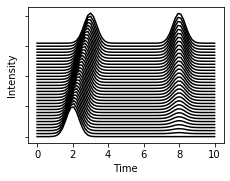

In [5]:
fig, ax = plt.subplots()

for i, row in enumerate(signal):
    ax.plot(x, row + i / 10, 'k-')

ax.set_yticklabels([])
ax.set_ylabel('Intensity')
ax.set_xlabel('Time')
fig.set_size_inches(3.5, 2.5)

As desired, we have a moving peak with constant contribution and a stationary peak that shows up in later rows

## Do Standard NMF
For a benchmark

In [6]:
nmf = NMF(n_components=2)
weights = nmf.fit_transform(signal)

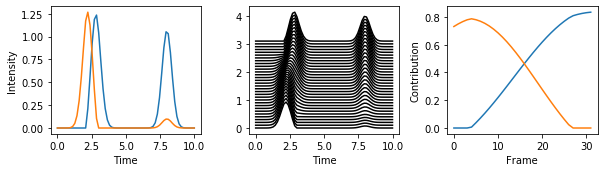

In [7]:
fig, axs = plt.subplots(1, 3)

# Plot the components
for comp in nmf.components_:
    axs[0].plot(x, comp)
axs[0].set_ylabel('Intensity')
    
# Plot the reconstruction
for i, row in enumerate(weights):
    axs[1].plot(x, np.dot(row, nmf.components_) + i / 10, 'k-')
    
for ax in axs[:2]:
    ax.set_xlabel('Time')
    
for w in weights.T:
    axs[2].plot(w)
axs[2].set_xlabel('Frame')
axs[2].set_ylabel('Contribution')

fig.set_size_inches(8.5, 2.5)
fig.tight_layout()

*Finding*: Not unsurprising, a low shift signal with no second peak and a shifted peak with a second peak.

## Use Our NMF with DTW
Using a regularization because there are an infinite set of possible solutions and I want a sparse one.

In [8]:
nmfdtw = NMFWithDTW(n_jobs=None, init='random', alpha=1e-3, l1_ratio=1, optimizer_args={'maxfun': 1000, 'disp': False})

Run some operations to start out with

In [9]:
%%time
weights = nmfdtw.fit_transform(signal)

Wall time: 54.1 s


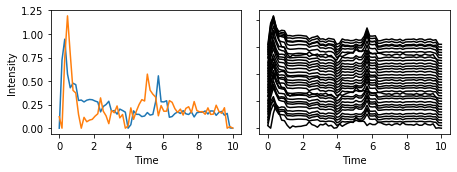

In [10]:
fig, axs = plt.subplots(1, 2)

# Plot the components
for comp in nmfdtw.components_:
    axs[0].plot(x, comp)
axs[0].set_ylabel('Intensity')
    
# Plot the reconstruction
for i, row in enumerate(weights):
    axs[1].plot(x, np.dot(row, nmfdtw.components_) + i / 10, 'k-')
axs[1].set_yticklabels([])

for ax in axs:
    ax.set_xlabel('Time')

fig.set_size_inches(6.5, 2.5)
fig.tight_layout()

*Finding*: The patterns do have some signal. They have two peaks but no indication of peak shifting and the peaks are in the wrong position.

Run some more and plot how the error changes

In [11]:
dtw_basic = [{'iter': 0, 'error': nmfdtw.reconstruction_error_}]
for i in tqdm(range(15)):
    weights = nmfdtw.fit_transform(signal, W=weights, H=nmfdtw.components_)
    dtw_basic.append({'iter': i+1, 'error': nmfdtw.reconstruction_error_})

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [09:41<00:00, 38.77s/it]


In [12]:
dtw_basic = pd.DataFrame(dtw_basic)

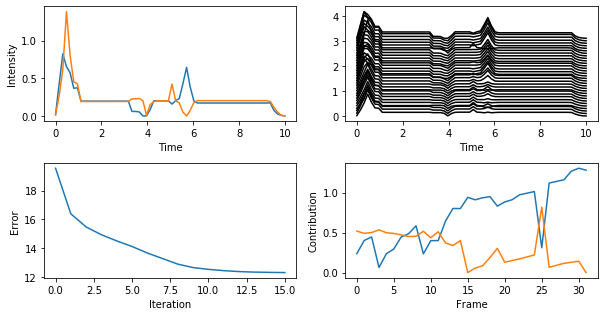

In [13]:
fig, axs = plt.subplots(2, 2)
axs = axs.flatten()

# Plot the components
for comp in nmfdtw.components_:
    axs[0].plot(x, comp)
axs[0].set_ylabel('Intensity')
    
# Plot the reconstruction
for i, row in enumerate(weights):
    axs[1].plot(x, np.dot(row, nmfdtw.components_) + i / 10, 'k-')
    
for ax in axs[:2]:
    ax.set_xlabel('Time')
    
axs[2].plot(dtw_basic['iter'], dtw_basic['error'])
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Error')

for w in weights.T:
    axs[3].plot(w)
axs[3].set_xlabel('Frame')
axs[3].set_ylabel('Contribution')

fig.set_size_inches(8.5, 4.5)
fig.tight_layout()

*Finding*: Not bad. I get two peaks, one grows and the other stays somewhat constant

## DTW combined with Regular Loss Function
Using only DTW means that *none* of the reconstructed patterns match the undistrted patterns.
In this test, we add a penalty term that corresponds to the mean absolute error between the reconstructed and original signal.
Mean absolute error is not outlier sensitive, so we avoid penalizing the solver too much for peak shifting.
For shorthand, we refer to this as "Pinned" DTW

In [14]:
nmfdtw = NMFWithDTW(n_jobs=None, init='random', alpha=1e-3, l1_ratio=1,
                    optimizer_args={'maxfun': 10000, 'disp': False}, absolute_error_weight=0.5)

In [15]:
dtw_pinned = []
for i in tqdm(range(16)):
    weights = nmfdtw.fit_transform(signal, W=weights, H=nmfdtw.components_)
    dtw_pinned.append({'iter': i+1, 'error': nmfdtw.reconstruction_error_})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [35:01<00:00, 131.33s/it]


In [16]:
dtw_pinned = pd.DataFrame(dtw_pinned)

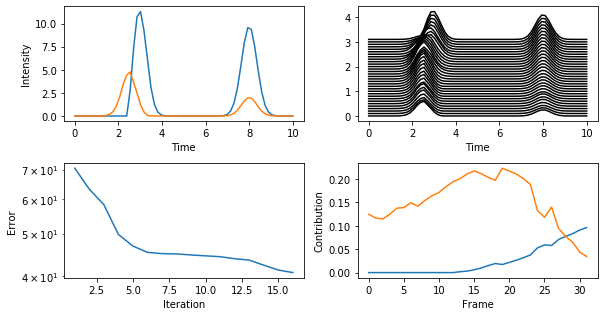

In [17]:
fig, axs = plt.subplots(2, 2)
axs = axs.flatten()

# Plot the components
for comp in nmfdtw.components_:
    axs[0].plot(x, comp)
axs[0].set_ylabel('Intensity')
    
# Plot the reconstruction
for i, row in enumerate(weights):
    axs[1].plot(x, np.dot(row, nmfdtw.components_) + i / 10, 'k-')
    
for ax in axs[:2]:
    ax.set_xlabel('Time')
    
axs[2].semilogy(dtw_pinned['iter'], dtw_pinned['error'])
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Error')

for w in weights.T:
    axs[3].plot(w)
axs[3].set_xlabel('Frame')
axs[3].set_ylabel('Contribution')

fig.set_size_inches(8.5, 4.5)
fig.tight_layout()

*Finding*: It is working OK. We still have a "shifted peak + second peak" combination.

**TODO**: Turn down the "it must match" criterion